## WHAT IS STAC

- STAC = Spatio-Temporal Asset Catalogs
- The Planetary Computer's database is an example of a STAC catalog, but there are many others


STACs are organized in the following way:

Catalog (ex. Planetary Computer Catalog)

    |____ Collection (ex. Landsat)
 
         |____ Item = basic info about scene at specific space and time point)
               Includes 
                  - GeoJson = geometry + coordinates
                  - time of scene
                  - thumbnail
                  - assets
                      |______ asset1 = info captured within the time and space
                              (ex. infrared band)
                      |______ asset2
           

An Item object represents a unit of data and metadata, typically representing a single scene of data at one place and time. A STAC Item is a GeoJSON Feature and can be easily read by any modern GIS or geospatial library, and it describes a SpatioTemporal Asset.  The STAC Item JSON specification uses the GeoJSON geometry to describe the location of the asset, and then includes additional information.

The GeoJSON is not the actual 'thing', but instead references files and serves as an index to the 'assets'. 

See STAC overview:
https://github.com/radiantearth/stac-spec/blob/v1.0.0/overview.md

## ACCESSING AND SEARCHING A STAC

- `pystac_client` is a library to access STAC catalogs.
- Once you access the STAC catalog via `pystac_client.Client.open` you can search the catalog.
- `catalog = pystac_client.Client.open(URL)`  is like opening the index
- `catalog.search` is specifying what you will want to work with 

See ItemSearch  to see what parameters can be included in the search
https://pystac-client.readthedocs.io/en/latest/api.html?highlight=catalog.search#pystac_client.ItemSearch

In [1]:
# ------ OPEN PLANETARY COMPUTER CATALOG -----

import pystac_client # access STAC catalogs

# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

In [2]:
# ---- STE OPEN AREA OF INTEREST FOR SEARCH ------

import rasterio.features

# Sedgwick bounding box
# Bounding box:  xmin: -120.0717 ymin: 34.67874 xmax: -120.0118 ymax: 34.74399 (WGS 84)

sedgwick = {
    "type": "Polygon",
    "coordinates": [
        [
            [-120.0118, 34.67874],  # x1, y1
            [-120.0118, 34.74399],  # x1, y2
            [-120.0717, 34.74399],  # x2, y2
            [-120.0717, 34.67874],  # x2, y2
        ]
    ],
}

# rasterio.features  module provides functions to extract shapes of raster features and create new features

# bounds = creates bounding box of polygon, 
bbox = rasterio.features.bounds(sedgwick)
print(type(bbox))
print(bbox)

<class 'tuple'>
(-120.0717, 34.67874, -120.0118, 34.74399)


In [3]:
# ----- SEARCH CATALOG ------

search = catalog.search(
    bbox = bbox,
    datetime = "2020-01-01/2020-06-30",
    collections = ["landsat-8-c2-l2"],  # select collection (see catalog browsing)
    limit = 500,  # fetch items in batches of 500  #?
    query = {"eo:cloud_cover": {"lt": 5}},   #???
)

In [4]:
# ---- EXPLORING TYPES OF search AND search_mathces ---

#ItemSearch instance
# <class 'pystac_client.item_search.ItemSearch'>
print(type(search))


# how many items match search requirements
search_matches = list(search.get_items())
print(len(search_matches))

# each element is a pystac.Item
# <class 'pystac.item.Item'>
print(type(search_matches[0]))

<class 'pystac_client.item_search.ItemSearch'>
2
<class 'pystac.item.Item'>


## SIGNING PLANETARY COMPUTER ITEMS

A SAS token is needed whenever you want to access Planetary Computer data at an Azure Blob URL.

https://planetarycomputer.microsoft.com/docs/concepts/sas/

In [5]:
import planetary_computer # signing Azure Blob Storage URLs

signed_items = []
for item in search_matches:
    item.clear_links()   #???
    signed_items.append(planetary_computer.sign(item).to_dict()) #???
    # signing Azure Blob storage URLs (?)
    
# no parameter is passed to the to_dict() method. 
# will convert the dataframe into a dictionary of dictionaries by default.

print(type(signed_items))

<class 'list'>


## CREATING A STACK OF STAC ITEMS

`stackstac.stack` creates an `xarray.DataArray` of all the STAC items, reprojected to the same grid and stacked by time.

The DataArray’s dimensions will be ("time", "band", "y", "x"). It’s backed by a lazy Dask array, so you can manipulate it without touching any data.


`stackstac.stack` documentation
https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html#stackstac.stack

In [6]:
import stackstac   # load data into xarray DataArray
import numpy as np

data = (
    stackstac.stack(
        signed_items,
        assets=["SR_B4", "SR_B3", "SR_B2"],  # red, green, blue
        #chunksize=4096,  #??
        #resolution=100,  #??
        #epsg = 32610, # had to specify a common CRS
    )
    .where(lambda x: x > 0, other=np.nan)  # ??
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

,Array,Chunk
Bytes,2.79 GiB,8.00 MiB
Shape,"(2, 3, 7962, 7842)","(1, 1, 1024, 1024)"
Count,1228 Tasks,384 Chunks
Type,float64,numpy.ndarray


## INITIALIZING DASK CLUSTER

To scale data processing using parallel computing we use the `dask` library

In [7]:
#  ------ INITIALIZE A DASK CLUSTER ------

from dask_gateway import GatewayCluster   


cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)  # choose # workers adaptatively 

# click on link to see Dask dashboard
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.9df8493aaa5a42bab50e75c52032bdd1/status


## COMPUTING A MEDIAN COMPOSITE

Here we calculate and plot a composite with the median of all the scenes in the data stacstack.

In [8]:
# ----- COMPUTE MEDIAN -----

median = data.median(dim="time").compute()

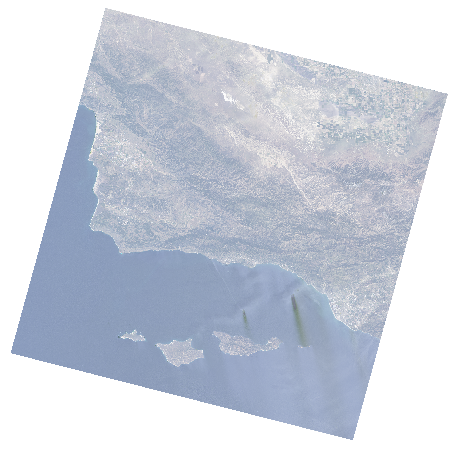

In [9]:
# ----- PLOT MEDIAN COMPOSITE ----

import xrspatial.multispectral as ms   #?
import matplotlib.pyplot as plt


image = ms.true_color(*median)  # expects red, green, blue DataArrays


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()
image.plot.imshow(ax=ax);

## ZOOMING INTO AREA OF INTEREST

In [10]:
# ----- SET CENTER OF ZOOM IN SQUARE -----

import pyproj

lon, lat =  -119.7, 34.4 # Santa Barbara
buffer = 2000
x_utm, y_utm = pyproj.Proj(data.crs)(lon, lat)  # change coords to data CRS
x_utm, y_utm

(251802.15819666997, 3809814.0301498836)

In [11]:
# ---- SLICING sarray.DataArray ----- 

# data.loc is indexing the data array by labels
# if you look at data we'll see that the coordinates are
#     time, band, y, x

aoi = data.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-7b733b4a93fcbd7be5e48c29dc9485db' (time: 2, band: 3, y: 133, x: 134)>
dask.array<getitem, shape=(2, 3, 133, 134), dtype=float64, chunksize=(1, 1, 133, 134), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2020-02-01T18:34:35.81...
    id                           (time) <U31 'LC08_L2SP_042036_20200201_02_T1...
  * band                         (band) <U5 'red' 'green' 'blue'
  * x                            (x) float64 2.498e+05 2.498e+05 ... 2.538e+05
  * y                            (y) float64 3.812e+06 3.812e+06 ... 3.808e+06
    description                  (band) <U56 'Collection 2 Level-2 Red Band (...
    ...                           ...
    title                        (band) <U15 'Red Band (B4)' ... 'Blue Band (...
    gsd                          float64 30.0
    common_name                  (band) <U5 'red' 'green' 'blue'
    center_wavelength            (band) float64 0.65 0.56 0.48
    full_width_half_max          (band) float64 0.04 0.06 0.06
    epsg                         int64 32611
Attributes:
    spec:        RasterSpec(epsg=32611, bounds=(121770.0, 3713670.0, 357030.0...
    crs:         epsg:32611
    transform:   | 30.00, 0.00, 121770.00|\n| 0.00,-30.00, 3952530.00|\n| 0.0...
    resolution:  30.0

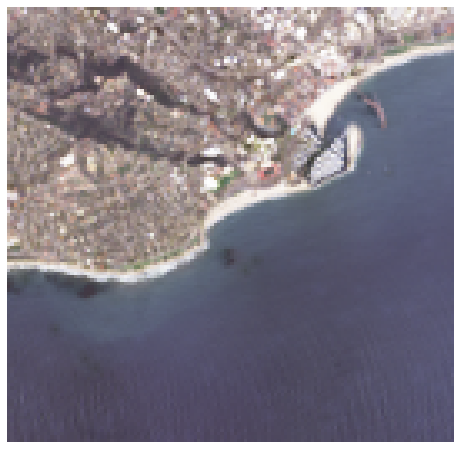

In [12]:
# ---- COMPUTE MEDIAN USING SLICED ARRAY ----

median_aoi = aoi.median(dim="time").compute()
image = ms.true_color(*median_aoi)  # expects red, green, blue DataArrays


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()
image.plot.imshow(ax=ax);

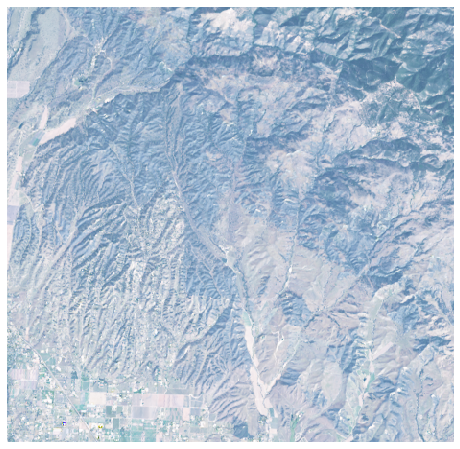

In [13]:
# ------ MEDIAN COMPOSITE FOR SEDGWICK ----

lon_sed, lat_sed = -120.04, 34.7  # Sedgwick
buffer = 7000
x_utm, y_utm = pyproj.Proj(data.crs)(lon_sed, lat_sed)
x_utm, y_utm

sed = data.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]

median_sed = sed.median(dim="time").compute()
image = ms.true_color(*median_sed)  # expects red, green, blue DataArrays


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()
image.plot.imshow(ax=ax);

In [14]:
# ---- EXPLORING DATA TYPES ---
print(type(median_sed))
#type(median_sed[0])

median_sed

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'stackstac-7b733b4a93fcbd7be5e48c29dc9485db' (band: 3, y: 467, x: 466)>
array([[[11056.5, 12571. , 11578. , ...,  9285.5,  9471.5,  8850. ],
        [11675.5, 11118.5, 10583. , ...,  9943. ,  9596. ,  9554. ],
        [11600. , 10455. ,  9555.5, ..., 10150. , 10644.5, 11266. ],
        ...,
        [10600.5,  9137. ,  8542. , ..., 11256.5, 11047. , 10614.5],
        [11184. ,  8954.5,  9073. , ..., 11408.5, 11119. , 11291. ],
        [12450. ,  9503.5,  9310.5, ..., 11373. , 11134. , 11675.5]],

       [[10642.5, 11574. , 10828. , ...,  9347. ,  9476. ,  8953.5],
        [11038. , 10583. , 10129.5, ...,  9608.5,  9324.5,  9306.5],
        [10957. , 10089.5,  9452.5, ..., 10069. , 10439. , 10869. ],
        ...,
        [10192. ,  9010.5,  8630.5, ..., 10403.5, 10326.5,  9935. ],
        [10818. ,  8887. ,  9044. , ..., 10574.5, 10264. , 10404. ],
        [11790.5,  9314.5,  9164.5, ..., 10530. , 10268.5, 10727. ]],

       [[ 9270. , 10197.5,  9662.5, ...,  8595.5,  8663.5,  8337.5],
        [ 9564. ,  9464.5,  9312.5, ...,  8705.5,  8492.5,  8501. ],
        [ 9552.5,  9200. ,  8820. , ...,  9202.5,  9379.5,  9484.5],
        ...,
        [ 8778. ,  8113.5,  8046.5, ...,  9314.5,  9242. ,  9113. ],
        [ 9574.5,  8206. ,  8237.5, ...,  9359.5,  9245. ,  9289. ],
        [10234.5,  8481. ,  8184.5, ...,  9415.5,  9309. ,  9500.5]]])
Coordinates: (12/20)
  * band                         (band) <U5 'red' 'green' 'blue'
  * x                            (x) float64 2.146e+05 2.146e+05 ... 2.285e+05
  * y                            (y) float64 3.851e+06 3.851e+06 ... 3.837e+06
    description                  (band) <U56 'Collection 2 Level-2 Red Band (...
    instruments                  object {'tirs', 'oli'}
    landsat:wrs_path             <U3 '042'
    ...                           ...
    title                        (band) <U15 'Red Band (B4)' ... 'Blue Band (...
    gsd                          float64 30.0
    common_name                  (band) <U5 'red' 'green' 'blue'
    center_wavelength            (band) float64 0.65 0.56 0.48
    full_width_half_max          (band) float64 0.04 0.06 0.06
    epsg                         int64 32611

## LOST CRS IN MEDIAN RASTER

We know the epsg of `median` raster from the previous cell or by knowing it comes from the data rasters (see `data.crs`), however we cannot access it directly using `median.crs`. Seems like the crs got lost while computing the median. 

We can use `.rio.write_crs` from `rioxarray` to set crs of median, but still cannot access it. However, if we don't set it manually here (or a before doing the masking) there's an error when trying `median.rio.clip`. 

In [15]:
print('CRS data :', data.crs)
#median.crs
# AttributeError: 'DataArray' object has no attribute 'crs'

CRS data : epsg:32611


AttributeError: 'DataArray' object has no attribute 'crs'

In [16]:
import rioxarray
# https://github.com/corteva/rioxarray/issues/213

median.rio.write_crs("epsg:32611", inplace=True)
#median.crs  # same AttributeError: 'DataArray' object has no attribute 'crs

<xarray.DataArray 'stackstac-7b733b4a93fcbd7be5e48c29dc9485db' (band: 3, y: 7962, x: 7842)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates: (12/21)
  * band                         (band) <U5 'red' 'green' 'blue'
  * x                            (x) float64 1.218e+05 1.218e+05 ... 3.57e+05
  * y                            (y) float64 3.953e+06 3.952e+06 ... 3.714e+06
    description                  (band) <U56 'Collection 2 Level-2 Red Band (...
    instruments                  object {'tirs', 'oli'}
    landsat:wrs_path             <U3 '042'
    ...                           ...
    gsd                          float64 30.0
    common_name                  (band) <U5 'red' 'green' 'blue'
    center_wavelength            (band) float64 0.65 0.56 0.48
    full_width_half_max          (band) float64 0.04 0.06 0.06
    epsg                         int64 32611
    spatial_ref                  int64 0

## MASKING WITH SHAPEFILE

In this example the shapefile and the raster have differnt CRS, so we need to make them match. We will change the CRS of the shp (epsg:3310) into the CRS of the raster (epsg:32611).

See `clip` documentation at:

https://corteva.github.io/rioxarray/stable/examples/clip_geom.html

In [17]:
# ---- OPENING SHAPEFILE ----

import geopandas as gpd # to open shapefile

sedg_shp_path = "/home/jovyan/Sedgwick_Reserve/sedgwick_geometry/sedgwick_geometry.shp"
sedg_shp_gpd = gpd.read_file(sedg_shp_path)
#sedg_shp_gpd.plot(edgecolor='purple', color='yellow')
sedg_shp_gpd.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
# ---- MATCHING CRS ----

sedg_shp_gpd = sedg_shp_gpd.to_crs(epsg=32611)  # change crs
sedg_shp_gpd.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

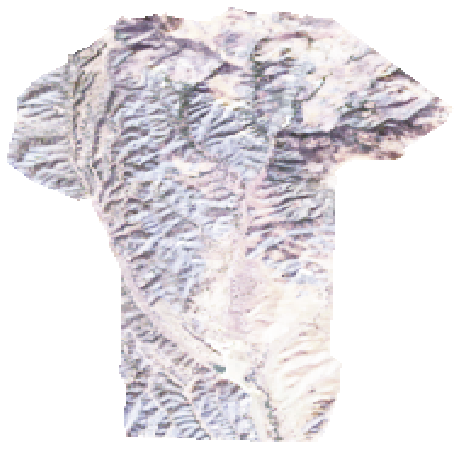

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [19]:
#import rioxarray

clipped = median.rio.clip(sedg_shp_gpd.geometry, 
                              sedg_shp_gpd.crs)

image = ms.true_color(*clipped)  # expects red, green, blue DataArrays


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()
image.plot.imshow(ax=ax);

In [ ]:
# ----- PLOTING INDIVIDUAL BANDS -----

#clipped[0].plot()
#clipped[1].plot()
#clipped[2].plot()